In [1]:
# import pandas_datareader
# from pandas_datareader import data, wb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [2]:
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from scipy import stats as ss

In [3]:
data = pd.read_csv('citibike_1520.csv')
data.head()

,Unnamed: 0,starttime_day,usertype,tripduration,tripdistance
0,0,2015-01-01,5317,801.806658,0.880446
1,1,2015-01-02,11304,731.240977,0.929326
2,2,2015-01-03,4478,655.284279,0.860687
3,3,2015-01-04,7849,679.554211,0.896166
4,4,2015-01-05,14506,637.811802,0.938065


In [4]:
#data = data.drop(columns='Unnamed: 0')
data= data.rename(columns={'usertype':'daily_counts'})
data['starttime_day'] = pd.to_datetime(data['starttime_day'])

In [5]:
data

,Unnamed: 0,starttime_day,daily_counts,tripduration,tripdistance
0,0,2015-01-01,5317,801.806658,0.880446
1,1,2015-01-02,11304,731.240977,0.929326
2,2,2015-01-03,4478,655.284279,0.860687
3,3,2015-01-04,7849,679.554211,0.896166
4,4,2015-01-05,14506,637.811802,0.938065
...,...,...,...,...,...
2118,26,2020-10-27,78030,969.498424,1.266052
2119,27,2020-10-28,62847,993.646172,1.244965
2120,28,2020-10-29,19072,861.612154,1.117977
2121,29,2020-10-30,39546,910.687023,1.123494


### Get summary

In [6]:
def getDfSummary(input_data):
    # Turn input into a dataframe
    data = pd.DataFrame(data=input_data)
    
    # Create a new data frame for the results
    index_names = list(input_data.columns)
    col_names = ['number_nan','percent_missing','number_distinct','mean','max','min','std','25%','50%','75%']
    df_summary = pd.DataFrame(columns = col_names,index = index_names)
        
    # Count the missing not-a-number values
    df_summary['number_nan'] = list(input_data.isna().sum())
    df_summary['percent_missing'] = list(input_data.isna().sum()/input_data.shape[0])
    
    # Count the number of distinct values for each variable
    df_summary['number_distinct'] = list(input_data.nunique())
    
    # Output the summary information of the input data
    data_describe = input_data.describe()
    summary_features = ['mean','max','min','std','25%','50%','75%']
    for i in summary_features:
        df_summary[i] = data_describe.loc[i]
    # Return the results  
    return df_summary

getDfSummary(data)

,number_nan,percent_missing,number_distinct,mean,max,min,std,25%,50%,75%
Unnamed: 0,0,0.0,31,14.680170,30.000000,0.000000,8.778826,7.000000,15.000000,22.000000
starttime_day,0,0.0,2123,NaN,NaN,NaN,NaN,NaN,NaN,NaN
daily_counts,0,0.0,2099,44690.419689,101462.000000,1107.000000,21284.594697,28541.000000,42738.000000,61085.000000
tripduration,0,0.0,2123,999.375561,2158.759199,569.858582,262.555638,812.762821,937.247620,1136.795286
tripdistance,0,0.0,2123,1.110741,3.684443,0.737004,0.149159,1.024329,1.101891,1.173625


### Train val test split

In [7]:
pre = data[data['starttime_day'] < '2020-03-01']
post = data[data['starttime_day'] >= '2020-03-01']

In [8]:
pre_train = pre.iloc[:-375,:]
pre_val = pre.iloc[-375:,:]

### Standardize data

In [9]:
from sklearn.preprocessing import StandardScaler
prescaler = StandardScaler()

In [10]:
prescaler.fit(np.array(pre_train['daily_counts']).reshape(-1,1))
pre_train['daily_counts_std'] = prescaler.transform(np.array(pre_train['daily_counts']).reshape(-1,1))
pre_val['daily_counts_std'] = prescaler.transform(np.array(pre_val['daily_counts']).reshape(-1,1))

### Dickey Fuller Test

P-value is 0.06 (>=0.05) so we cannot reject the null hypothesis and cannot conclude that the data is stationary.

In [11]:
#Define a function that performs Dickey-Fuller test and plot the moving average/moving std:

def DF_test(data, datecol='starttime_day', values='daily_counts_std'):
    dftest = adfuller(data[values], autolag = 'AIC')

    dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic','p-value','#Lags Used', 'Num of obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print('Results of Dickey-Fuller test:')    
    print(dfoutput)

    plt.figure(figsize=(20,10))

    ig, ax = plt.subplots(figsize=(20, 5))
    org = ax.plot(data[datecol], data[values])

    plt.title('Citibike Daily Data (2015-2020)')
    plt.legend(loc= 'best')
    plt.show(block=False)

No handles with labels found to put in legend.


Results of Dickey-Fuller test:
Test Statistic            -2.503489
p-value                    0.114628
#Lags Used                22.000000
Num of obs              1480.000000
Critical Value (1%)       -3.434776
Critical Value (5%)       -2.863495
Critical Value (10%)      -2.567811
dtype: float64


<Figure size 1440x720 with 0 Axes>

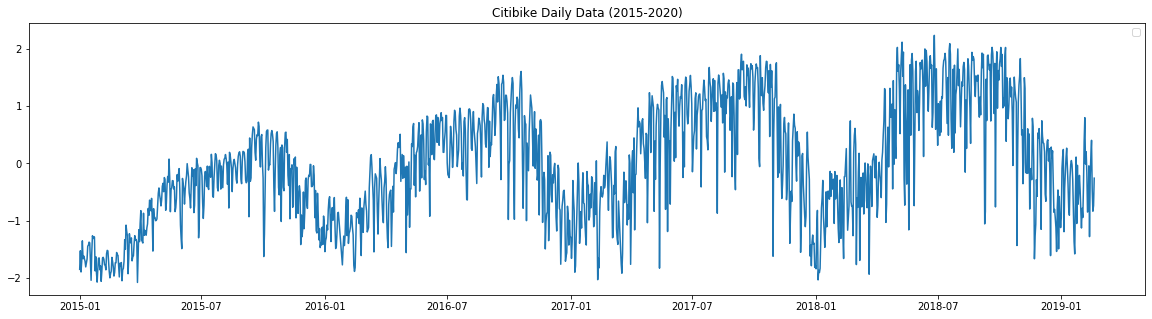

In [12]:
DF_test(pre_train)

### Plot ACF, PACF

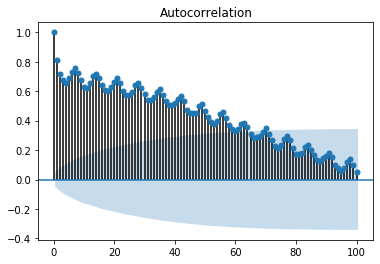

In [13]:
plot_acf(x=pre_train['daily_counts_std'], lags=100)
plt.show()

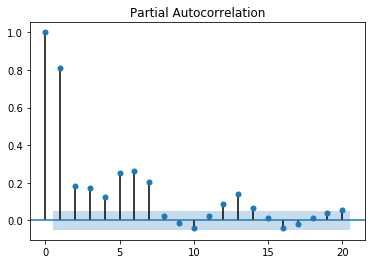

In [14]:
plot_pacf(x=pre_train['daily_counts_std'], lags=20)
plt.show()

### Trend decomposition

In [15]:
pre_train['daily_counts_std']

0      -1.851929
1      -1.526833
2      -1.897486
3      -1.714441
4      -1.352964
          ...   
1498    0.404027
1499   -0.455491
1500   -0.835429
1501   -0.738232
1502   -0.257729
Name: daily_counts_std, Length: 1503, dtype: float64

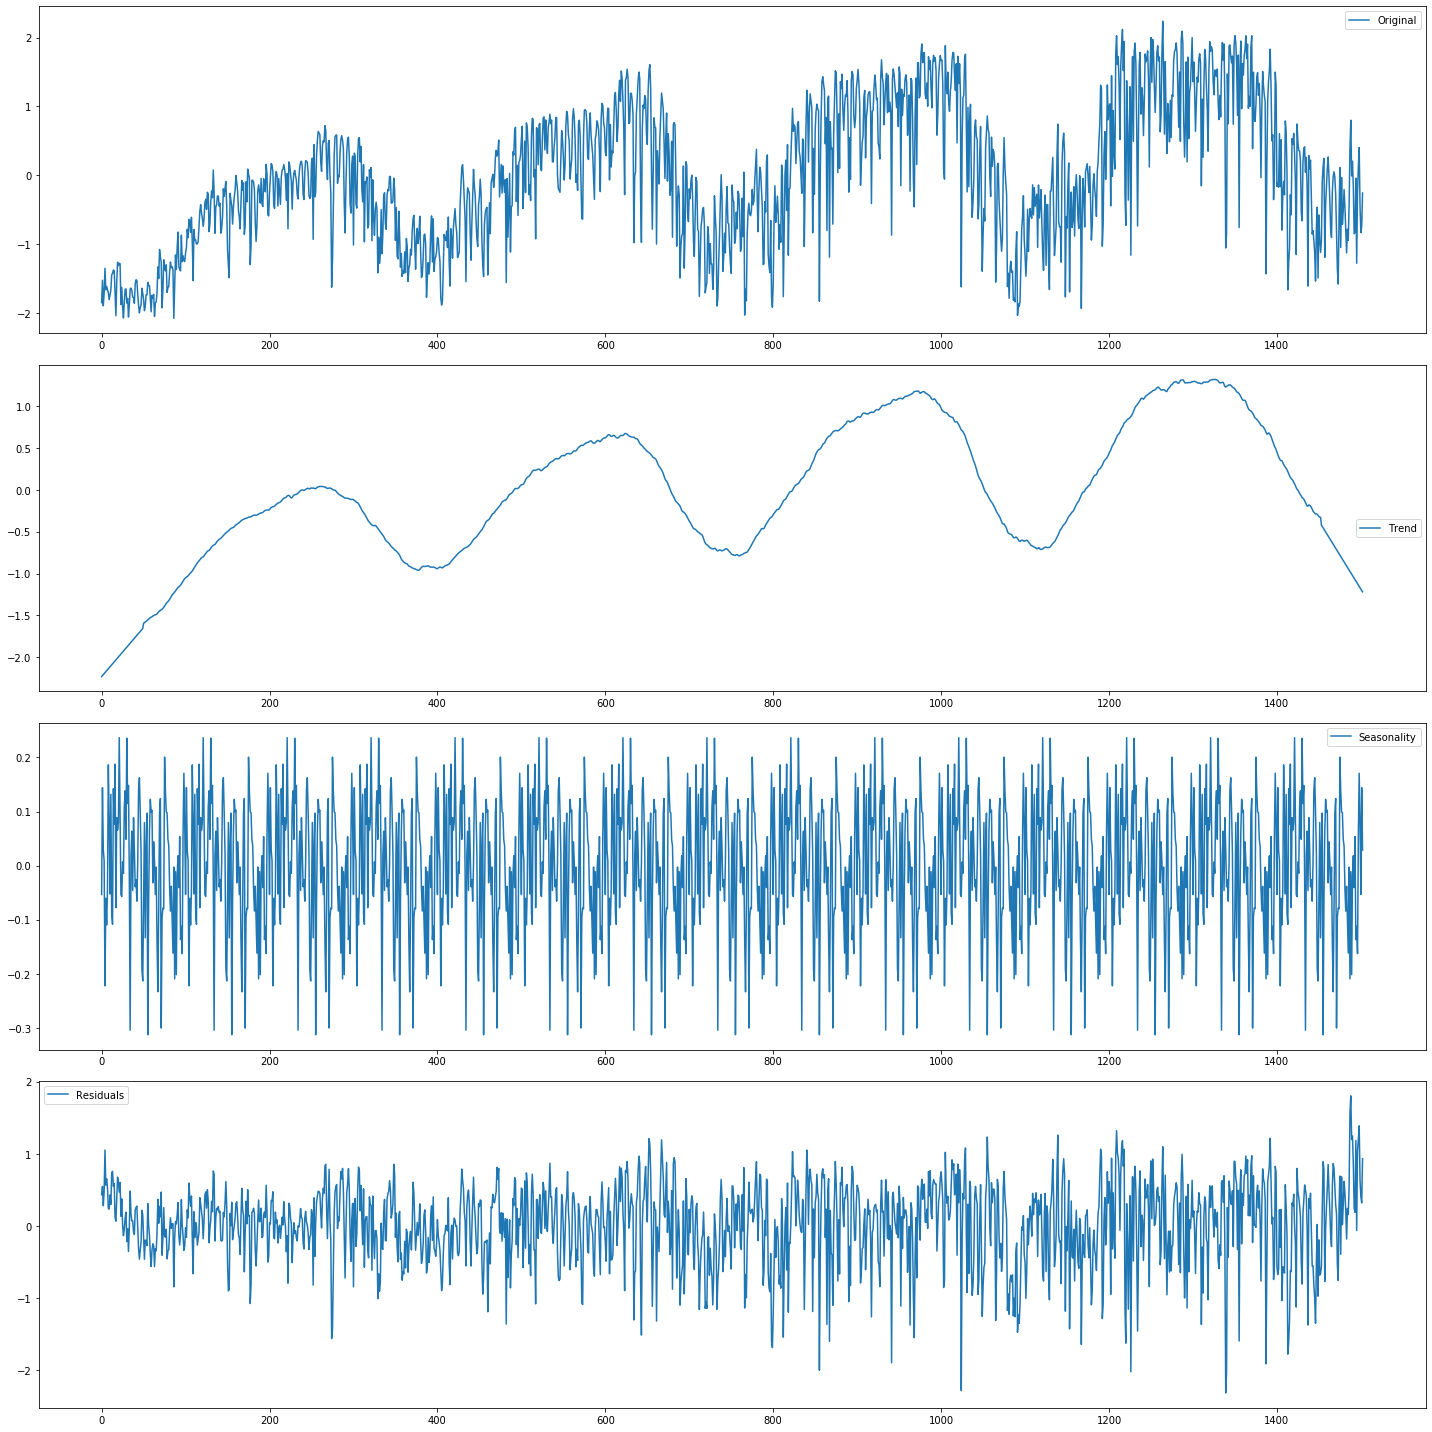

In [16]:
dt = pre_train['daily_counts_std']
decomposition = seasonal_decompose(dt,model='additive',freq=100, extrapolate_trend = 100)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(20, 20))

plt.subplot(411)
plt.plot(dt,label='Original')
plt.legend(loc= 'best')

plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc='center right')

plt.subplot(413)
plt.plot(seasonal, label ='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual,label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

### ARIMA model

In [17]:
def plot_RSS(model_name, results_data, orig_data, title=True):
    plt.figure(figsize=(20,7))
    fitted_values = results_data.fittedvalues
    plt.plot(orig_data, label = 'Original data')
    plt.plot(fitted_values, color='red', label='Fitted values')
    if title:
        plt.title(model_name+' Model'+' | MSE: %.4f'% np.mean((fitted_values - orig_data).dropna()**2),fontsize =20)
    plt.tight_layout()
    plt.legend()

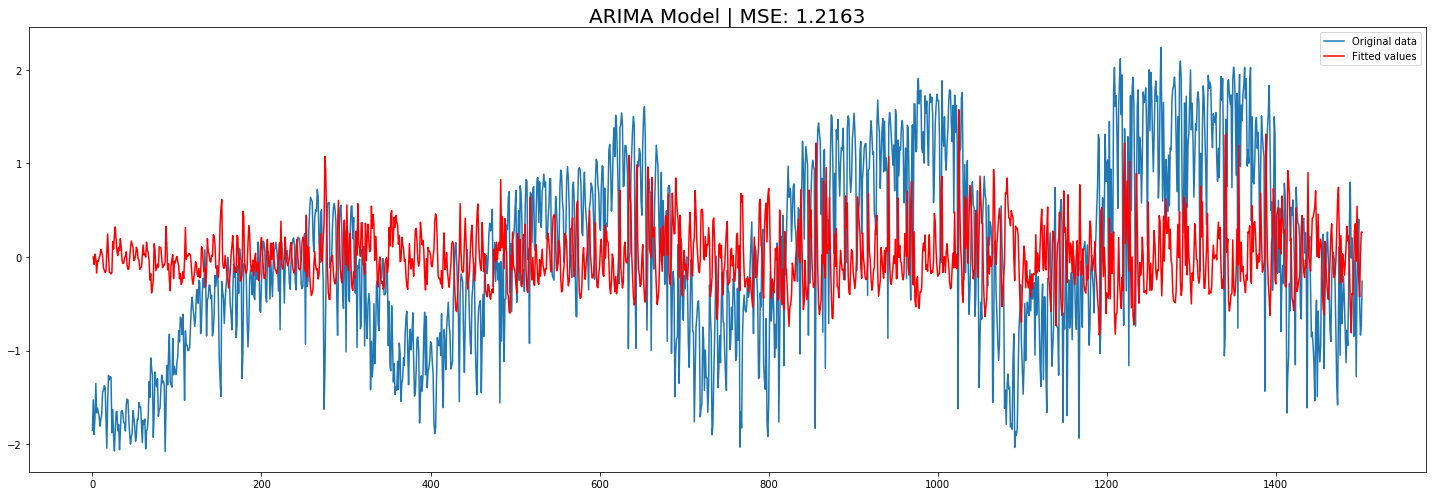

In [18]:
model = ARIMA(dt, order= (2,1,2))
results_ARIMA = model.fit(disp = False)

plot_RSS('ARIMA', results_ARIMA,dt)

### Use log

In [19]:
dtlog = np.log(np.array(pre_train['daily_counts']))

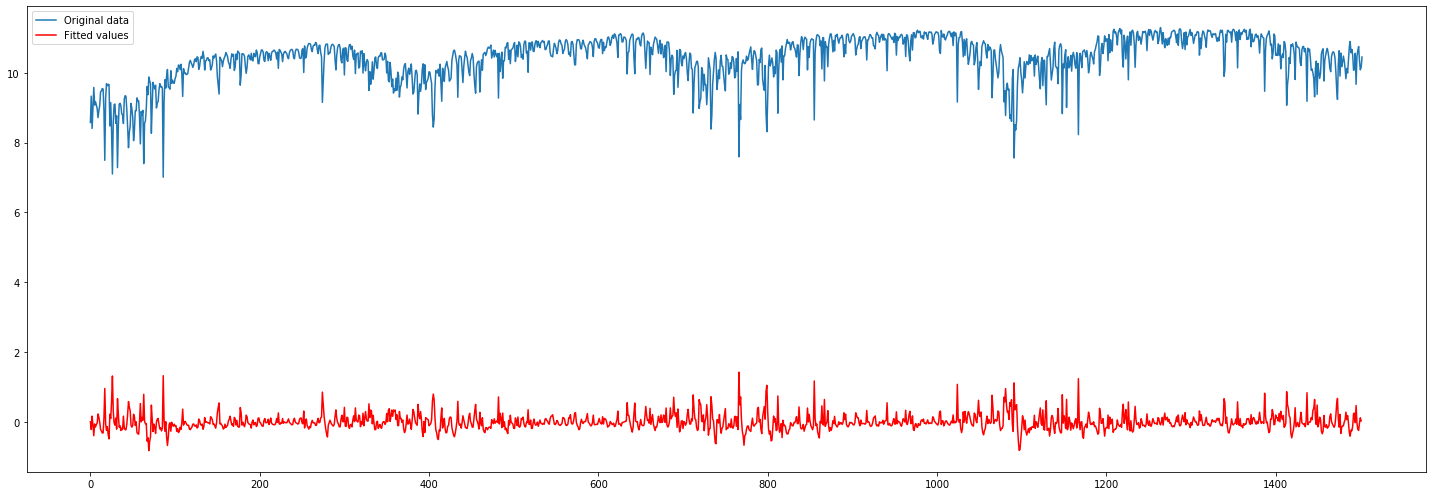

In [20]:
model = ARIMA(dtlog, order= (8,1,2))
results_ARIMA = model.fit(disp = False)

plot_RSS('ARIMA', results_ARIMA, dtlog, title=False)

### Use diff

In [21]:
def DF_test_2(data):
    dftest = adfuller(data, autolag = 'AIC')

    dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic','p-value','#Lags Used', 'Num of obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print('Results of Dickey-Fuller test:')    
    print(dfoutput)

    plt.figure(figsize=(20,10))

    ig, ax = plt.subplots(figsize=(20, 5))
    org = ax.plot(data)

    plt.title('Citibike Daily Data (2015-2020)')
    plt.legend(loc= 'best')
    plt.show(block=False)

No handles with labels found to put in legend.


Results of Dickey-Fuller test:
Test Statistic         -1.076341e+01
p-value                 2.487494e-19
#Lags Used              2.100000e+01
Num of obs              1.480000e+03
Critical Value (1%)    -3.434776e+00
Critical Value (5%)    -2.863495e+00
Critical Value (10%)   -2.567811e+00
dtype: float64


<Figure size 1440x720 with 0 Axes>

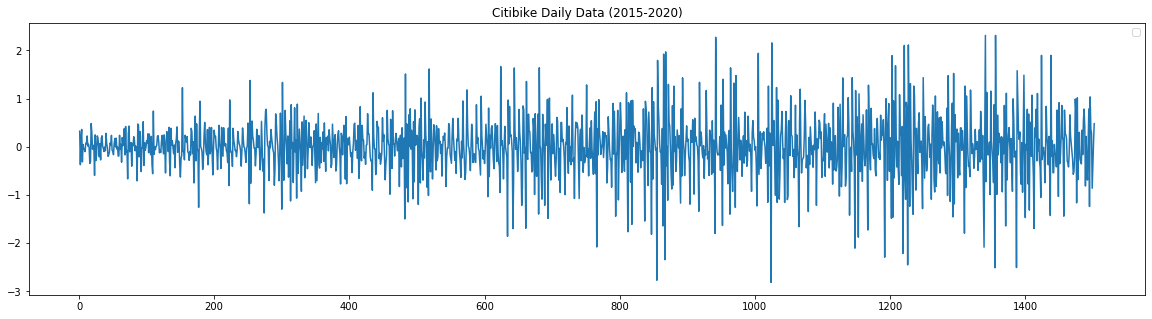

In [22]:
#Select data difference
diffshift = dt - dt.shift().fillna(0)

diffshift = diffshift[1:]
#Check DF test
DF_test_2(diffshift)

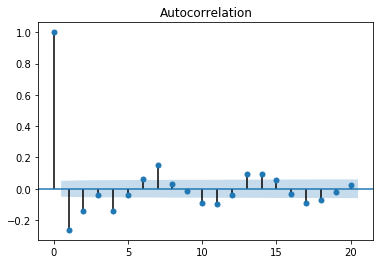

In [23]:
plot_acf(x=diffshift, lags=20)
plt.show()

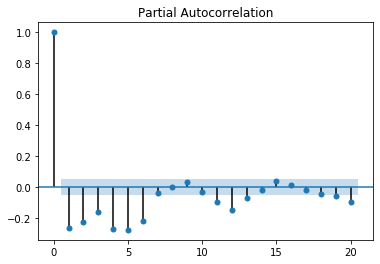

In [24]:
plot_pacf(x=diffshift, lags=20)
plt.show()

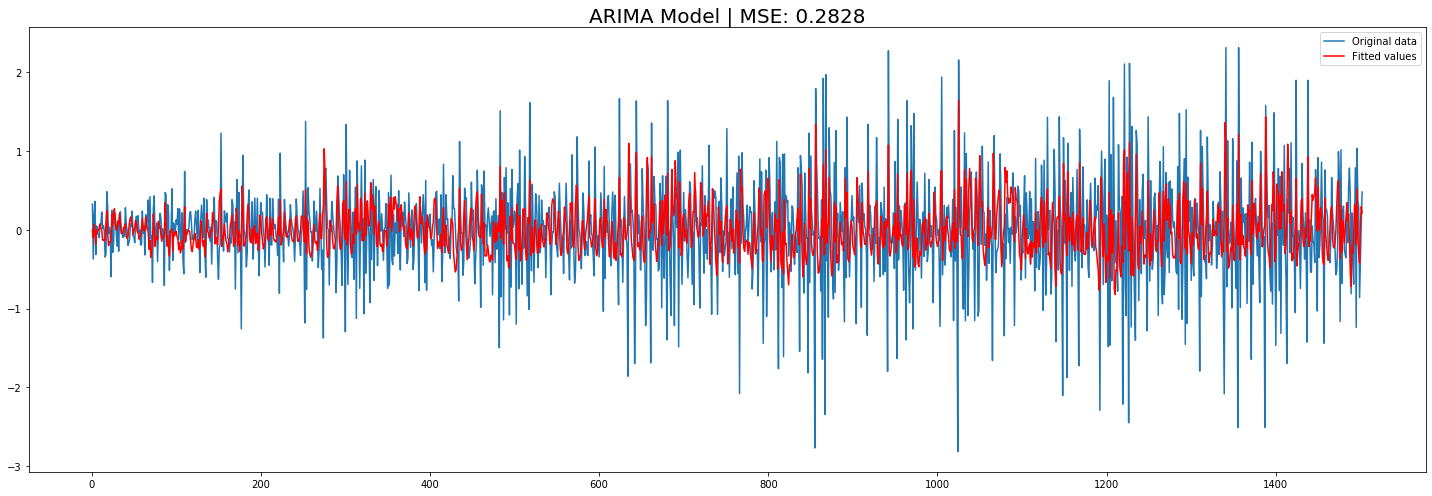

In [28]:
model = ARIMA(diffshift, order= (1,0,1))
model_ARIMA = model.fit(disp = False)

plot_RSS('ARIMA', model_ARIMA, diffshift)

#### Predict 1st-order difference using ARIMA

In [96]:
np.random.seed(0)
diff_predict = model_ARIMA.predict(start=0,end=374,exog=None, dynamic=False)
diff_predict = np.array(diff_predict)
diff_predict[:5]

array([ 0.00086943, -0.10263407,  0.0705183 , -0.02423335, -0.18885688])

In [97]:
last_train = pre_train['daily_counts_std'].tolist()[-1]
last_train

-0.25772948828163006

In [98]:
diff_predict= np.concatenate([[last_train], diff_predict])

In [99]:
diff_predict[:5]

array([-0.25772949,  0.00086943, -0.10263407,  0.0705183 , -0.02423335])

In [100]:
diff_predict[0]+diff_predict[1]

-0.2568600613757498

In [101]:
x_predict = np.cumsum(diff_predict)
len(x_predict)

376

In [107]:
len(x_predict[1:])

375

In [105]:
def MSE(pred):
    val = pre_val['daily_counts_std']
    MSE = np.mean((val-pred)**2)
    return MSE

Text(0.5, 1.0, 'Standardized predicted & true values (using ARIMA on residuals) | MSE:47.9592')

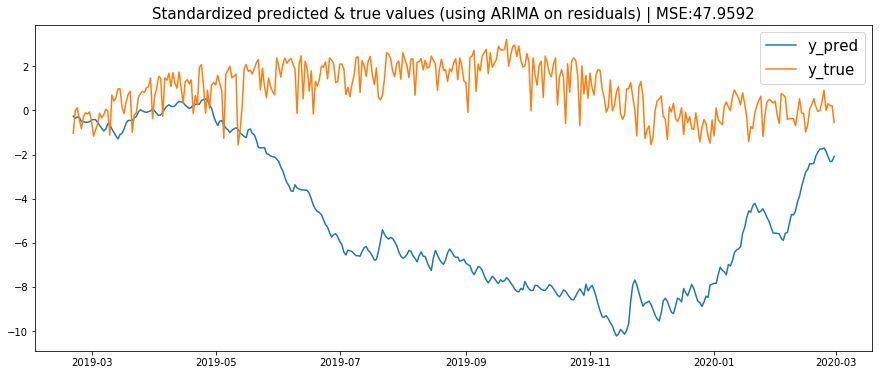

In [109]:
plt.figure(figsize=(15,6))
plt.plot(pre_val['starttime_day'],x_predict[1:], label = 'y_pred')
plt.plot(pre_val['starttime_day'],pre_val['daily_counts_std'], label = 'y_true')
plt.legend(fontsize=15)
MSE_ = MSE(x_predict[1:])
plt.title('Standardized predicted & true values (using ARIMA on residuals) | MSE:{:.4f}'.format(MSE_), fontsize=15)
#plt.title('Standardized predicted & true values (using ARIMA on residuals)', fontsize=15)

### Use residual

In [26]:
residual

0       0.430828
1       0.546704
2       0.279778
3       0.470496
4       1.051936
          ...   
1498    1.386481
1499    0.634716
1500    0.403792
1501    0.319735
1502    0.931929
Name: resid, Length: 1503, dtype: float64

No handles with labels found to put in legend.


Results of Dickey-Fuller test:
Test Statistic         -7.109365e+00
p-value                 3.975972e-10
#Lags Used              2.200000e+01
Num of obs              1.480000e+03
Critical Value (1%)    -3.434776e+00
Critical Value (5%)    -2.863495e+00
Critical Value (10%)   -2.567811e+00
dtype: float64


<Figure size 1440x720 with 0 Axes>

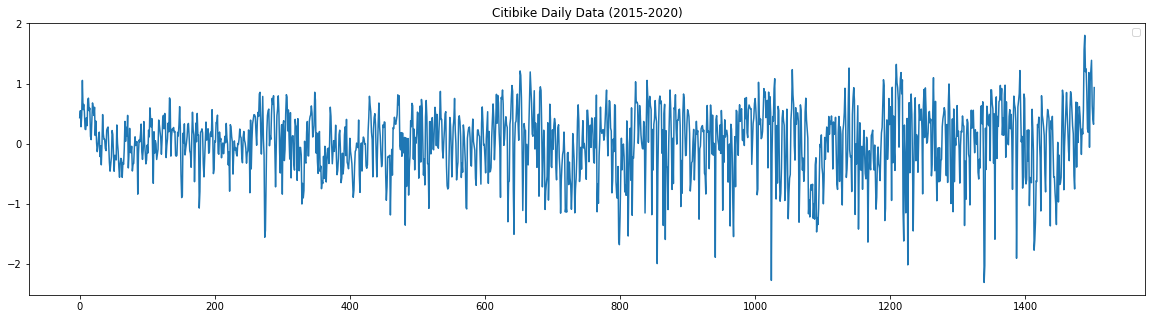

In [27]:
DF_test_2(residual)

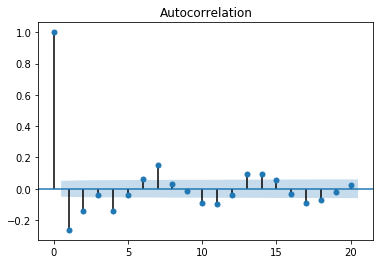

In [28]:
plot_acf(x=diffshift, lags=20)
plt.show()

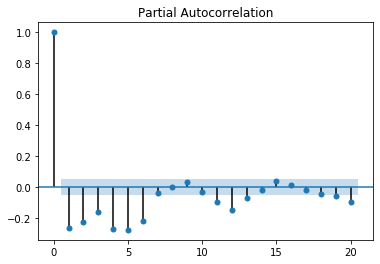

In [29]:
plot_pacf(x=diffshift, lags=20)
plt.show()

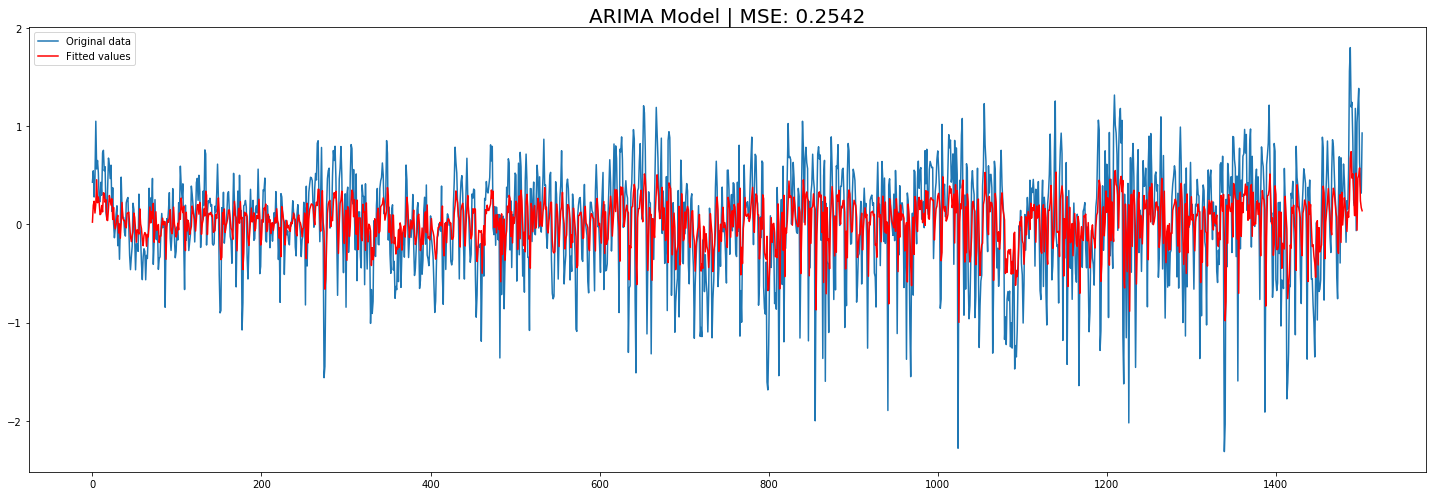

In [30]:
model = ARIMA(residual, order= (1,0,1))
model_ARIMA = model.fit(disp = False)

plot_RSS('ARIMA', model_ARIMA, residual)

#### ARIMA Prediction

In [31]:
pre_val

,Unnamed: 0,starttime_day,daily_counts,tripduration,tripdistance,daily_counts_std
1503,19,2019-02-20,20426,739.450553,0.983211,-1.031507
1504,20,2019-02-21,39499,787.196182,1.047477,0.004160
1505,21,2019-02-22,41794,784.932024,1.023959,0.128779
1506,22,2019-02-23,31608,849.226177,0.988002,-0.424322
1507,23,2019-02-24,24272,812.313818,0.955752,-0.822669
...,...,...,...,...,...,...
1873,24,2020-02-25,39568,819.709083,1.032943,0.007907
1874,25,2020-02-26,45207,815.924370,1.032638,0.314106
1875,26,2020-02-27,43411,692.327590,0.984672,0.216583
1876,27,2020-02-28,43360,701.421587,0.974092,0.213813


In [47]:
resid_predict = model_ARIMA.predict(start=1,end =375,exog=None, dynamic=False)
#resid_predict, trend[-375:], seasonal[-375:]
x_predict = np.array(resid_predict) + np.array(trend[-375:]) + np.array(seasonal[-375:]) 

In [49]:
MSE(x_predict), np.mean(x_predict), np.mean(pre_val['daily_counts_std'])

(0.9322811827214744, 0.45887641878574853, 0.9482589442053849)

Text(0.5, 1.0, 'Standardized predicted & true values (using ARIMA on residuals) | MSE:0.9323')

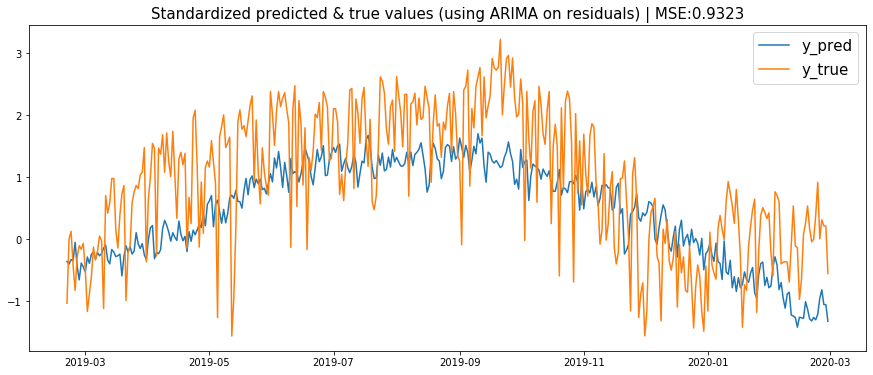

In [76]:
plt.figure(figsize=(15,6))
plt.plot(pre_val['starttime_day'],x_predict, label = 'y_pred')
plt.plot(pre_val['starttime_day'],pre_val['daily_counts_std'], label = 'y_true')
plt.legend(fontsize=15)
MSE_ = MSE(x_predict)
plt.title('Standardized predicted & true values (using ARIMA on residuals) | MSE:{:.4f}'.format(MSE_), fontsize=15)
#plt.title('Standardized predicted & true values (using ARIMA on residuals)', fontsize=15)

Text(0.5, 1.0, 'Scaled predicted & true values')

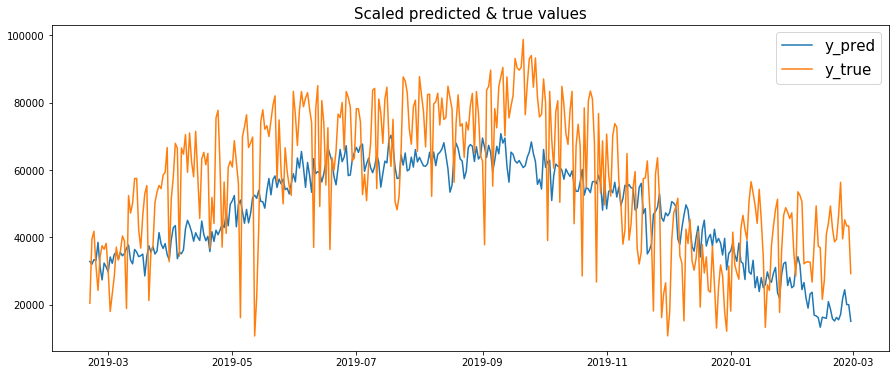

In [60]:
plt.figure(figsize=(15,6))
x_predict_scale = prescaler.inverse_transform(x_predict)
plt.plot(pre_val['starttime_day'],x_predict_scale, label = 'y_pred')
plt.plot(pre_val['starttime_day'],pre_val['daily_counts'], label = 'y_true')
plt.legend(fontsize=15)
#plt.title('Standardized predicted & true values (using ARIMA on residuals) | MSE:{}'.format(MSE_), fontsize=15)
plt.title('Scaled predicted & true values', fontsize=15)

### HMM 

In [62]:
resid = np.array(residual).reshape(-1,1)

In [63]:
import hmmlearn
from hmmlearn.hmm import GaussianHMM

In [33]:
def plotTimeSeries(X, K, ylabel='SP500 Returns'):
    """ 
    Inputs: X (data), K (number of hidden states)
    Do:
    1. Fit Gaussian HMM model on X
    2. Output transition matrix, mean and covar of each hidden state
    3. Plot hidden states
    """
    model = GaussianHMM(n_components=K, covariance_type="diag", n_iter=1000).fit(X)
    print("Transition matrix")
    print(model.transmat_)
    print()
    print("Means and vars of each hidden state")
    for i in range(model.n_components):
        print("{0}th hidden state".format(i))
        print("mean = ", model.means_[i])
        print("var = ", np.diag(model.covars_[i]))
        print()
    
    hidden_states = model.predict(X)

    #Plot hidden states
    sns.set()
    plt.figure(figsize=(15,6))
    xs = np.arange(len(X))
    for i in range(K):
        masks = hidden_states == i
        plt.scatter(xs[masks], X[masks], label='Hidden State {}'.format(i))
        plt.plot(xs, X, c='k')
    plt.title('SP500 Returns | Plot of hidden states')
    plt.xlabel('Time step')
    plt.ylabel(ylabel)
    plt.subplots_adjust(bottom=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='best', ncol=K,frameon=True)
    plt.show()

In [34]:
def plotDistribution(X, K):
    """
    Inputs: X (data), K (number of hidden states)
    Do: Plot the distribution of each hidden states
    """
    # fit Gaussian HMM to Q
    model = GaussianHMM(n_components=K, n_iter=1000).fit(np.reshape(X,[len(X),1]))
     
    # classify each observation as state 0 or 1
    hidden_states = model.predict(np.reshape(X,[len(X),1]))
 
    # find parameters of Gaussian HMM
    mu = np.array(model.means_)
    sigmas = np.array(np.sqrt(np.array([np.diag(model.covars_[i]) for i in range(K)])))
   
    P = np.array(model.transmat_)
 
    # find log-likelihood of Gaussian HMM
    logProb = model.score(np.reshape(X,[len(X),1]))

    # calculate stationary distribution
    eigenvals, eigenvecs = np.linalg.eig(np.transpose(P))
    one_eigval = np.argmin(np.abs(eigenvals-1))
    pi = eigenvecs[:,one_eigval] / np.sum(eigenvecs[:,one_eigval])
    
    
    sns.set()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist(X, bins=20, color='b', alpha=0.5, density=True)
    #colors = ['k','b','orange', 'red']
    Nsamp = 1000
    for i in range(K):
        masks = hidden_states == i
        print('Hidden state {} | number of obs: {}'.format(i, sum(masks)))
        #adjust the probability to make it != 0 (visualization and analysis purpose)
        if pi[i] <0.2:
            pii = 0.2
        else:
            pii = pi[i]
        x_i = np.linspace(mu[i]-4*sigmas[i], mu[i]+4*sigmas[i], Nsamp)
        fx_i = pii*ss.norm.pdf(x_i,mu[i],sigmas[i])
        plt.plot(x_i, fx_i,label='Hidden State {}'.format(i))

    fig.legend(loc='best', ncol=3, frameon=True)
    return None


Transition matrix
[[0.7533771  0.2466229 ]
 [0.18131319 0.81868681]]

Means and vars of each hidden state
0th hidden state
mean =  [-0.39559592]
var =  [0.25719384]

1th hidden state
mean =  [0.33066733]
var =  [0.12391182]



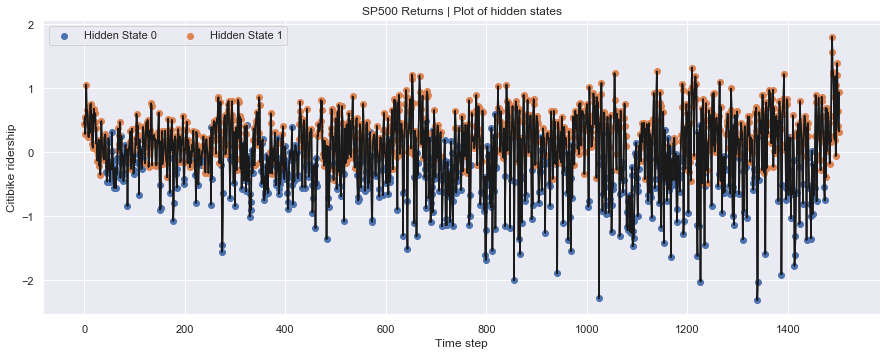

In [35]:
plotTimeSeries(resid, 2, ylabel='Citibike ridership')

Hidden state 0 | number of obs: 916
Hidden state 1 | number of obs: 587


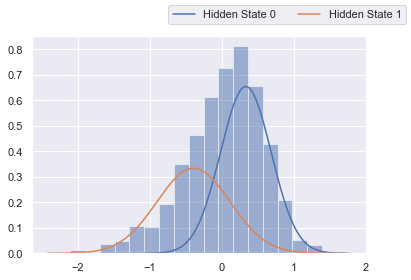

In [36]:
plotDistribution(resid, 2)

Transition matrix
[[0.92999742 0.00762385 0.06237873]
 [0.01250914 0.81500804 0.17248282]
 [0.05508081 0.23059298 0.7143262 ]]

Means and vars of each hidden state
0th hidden state
mean =  [-0.00395449]
var =  [0.0922841]

1th hidden state
mean =  [0.44441266]
var =  [0.1115748]

2th hidden state
mean =  [-0.49292726]
var =  [0.28848018]



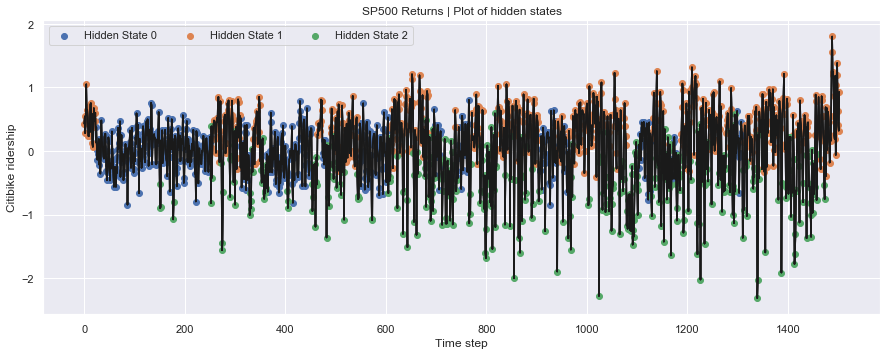

In [37]:
plotTimeSeries(resid, 3, ylabel='Citibike ridership')

Hidden state 0 | number of obs: 397
Hidden state 1 | number of obs: 581
Hidden state 2 | number of obs: 525


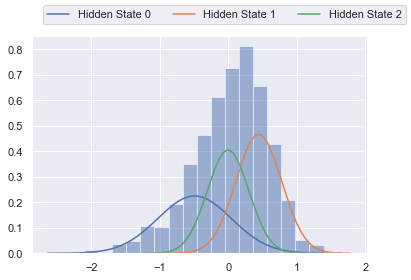

In [38]:
plotDistribution(resid, 3)

Transition matrix
[[6.02387325e-01 1.41664744e-01 1.67991667e-01 8.79562646e-02]
 [1.36596806e-01 5.53414432e-01 1.89239762e-01 1.20748999e-01]
 [1.05030688e-01 2.20568616e-01 6.73850301e-01 5.50395729e-04]
 [1.14066364e-01 1.50514446e-01 1.00050031e-01 6.35369159e-01]]

Means and vars of each hidden state
0th hidden state
mean =  [-0.6279829]
var =  [0.2682683]

1th hidden state
mean =  [0.34653187]
var =  [0.03672902]

2th hidden state
mean =  [-0.11512825]
var =  [0.06784806]

3th hidden state
mean =  [0.69796356]
var =  [0.07698496]



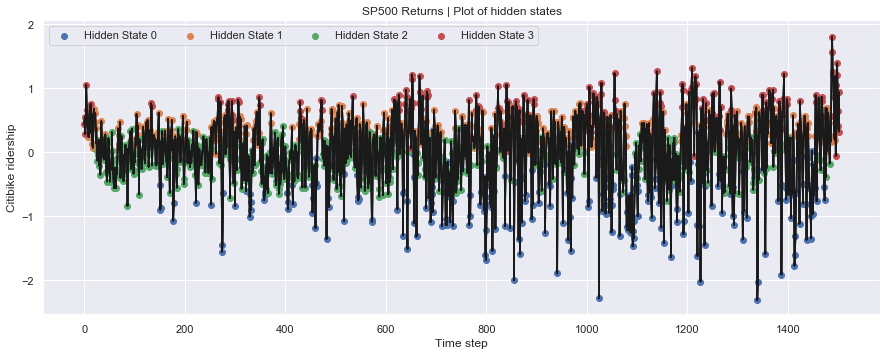

In [39]:
plotTimeSeries(resid, 4, ylabel='Citibike ridership')

Hidden state 0 | number of obs: 460
Hidden state 1 | number of obs: 557
Hidden state 2 | number of obs: 274
Hidden state 3 | number of obs: 212


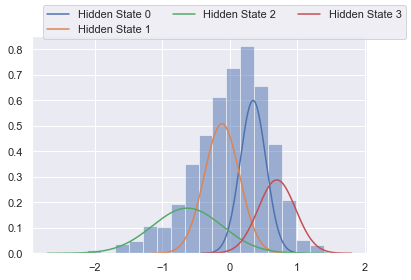

In [40]:
plotDistribution(resid, 4)

Transition matrix
[[6.49351516e-01 3.44738792e-05 2.22222156e-01 1.68832414e-03
  1.26703531e-01]
 [3.22769887e-03 4.85841725e-01 3.14905916e-01 1.75689497e-01
  2.03351630e-02]
 [2.30716801e-08 1.59214900e-01 5.93271827e-01 1.56366183e-01
  9.11470657e-02]
 [2.14297614e-01 2.74045564e-02 1.60739486e-01 4.85835776e-01
  1.11722568e-01]
 [9.75690905e-02 2.49917038e-01 8.06373540e-02 5.10769511e-02
  5.20799566e-01]]

Means and vars of each hidden state
0th hidden state
mean =  [0.68324858]
var =  [0.08496039]

1th hidden state
mean =  [-0.41911594]
var =  [0.07288204]

2th hidden state
mean =  [0.0670571]
var =  [0.04230822]

3th hidden state
mean =  [0.441193]
var =  [0.02471198]

4th hidden state
mean =  [-0.68923026]
var =  [0.33817842]



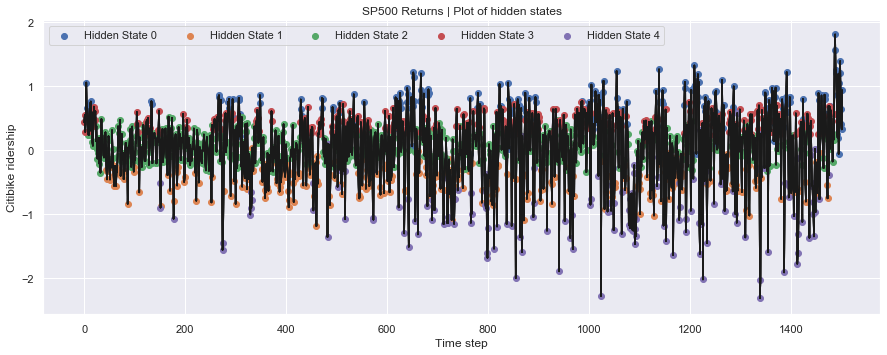

In [41]:
plotTimeSeries(resid, 5, ylabel='Citibike ridership')

Hidden state 0 | number of obs: 215
Hidden state 1 | number of obs: 289
Hidden state 2 | number of obs: 558
Hidden state 3 | number of obs: 280
Hidden state 4 | number of obs: 161


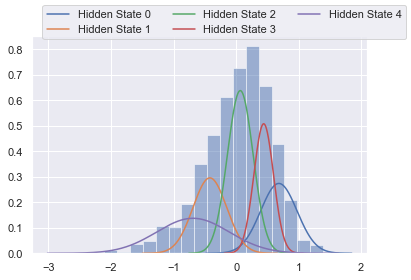

In [42]:
plotDistribution(resid, 5)

Transition matrix
[[5.20594787e-01 2.69298458e-02 7.83408311e-02 6.42395100e-02
  7.38983743e-02 2.35996651e-01]
 [2.61999171e-02 2.98294970e-01 1.89435773e-02 1.32761479e-12
  4.88226811e-01 1.68334725e-01]
 [1.08710100e-02 7.23954196e-02 4.54412386e-01 1.19085369e-15
  1.64244277e-01 2.98076908e-01]
 [1.79798153e-07 8.38743760e-02 1.26023984e-01 7.90101460e-01
  9.70338850e-11 8.52455551e-11]
 [1.20059128e-01 2.21121594e-02 1.77039960e-01 1.05072088e-02
  4.88260581e-01 1.82020963e-01]
 [1.88239833e-01 2.36875874e-02 1.92627382e-01 6.60940881e-16
  1.75053496e-01 4.20391701e-01]]

Means and vars of each hidden state
0th hidden state
mean =  [0.61224326]
var =  [0.03045721]

1th hidden state
mean =  [-1.24863277]
var =  [0.15826506]

2th hidden state
mean =  [-0.08796725]
var =  [0.02858021]

3th hidden state
mean =  [0.69211999]
var =  [0.18276397]

4th hidden state
mean =  [-0.48792336]
var =  [0.08582894]

5th hidden state
mean =  [0.27049217]
var =  [0.0220042]



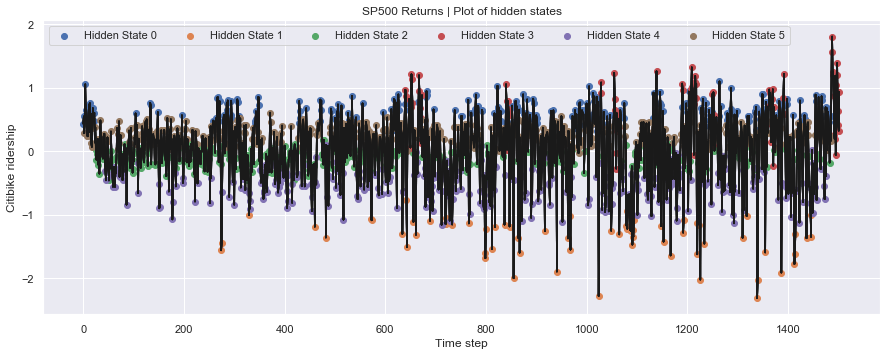

In [43]:
plotTimeSeries(resid, 6, ylabel='Citibike ridership')

Hidden state 0 | number of obs: 255
Hidden state 1 | number of obs: 68
Hidden state 2 | number of obs: 318
Hidden state 3 | number of obs: 83
Hidden state 4 | number of obs: 441
Hidden state 5 | number of obs: 338


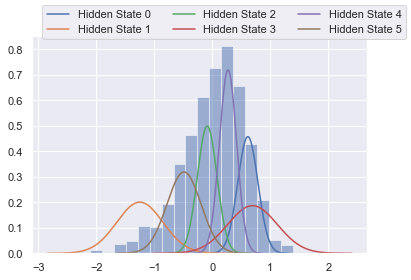

In [44]:
plotDistribution(resid, 6)

### HMM Prediction
Fit on resid

In [47]:
np.random.seed(0)
K = 6
model = GaussianHMM(n_components=K, covariance_type="diag", n_iter=1000).fit(resid)

In [50]:
# pred  = model.predict(resid)
# pred

array([1, 1, 5, ..., 3, 3, 3])

In [55]:
dec = model.sample(375)

In [66]:
seq, state = dec
len(seq)

375

In [70]:
seq = seq.flatten()

In [62]:
val = pre_val['daily_counts_std']
len(val), val.shape

(375, (375,))

In [83]:
#quick validation
def MSE(pred):
    val = pre_val['daily_counts_std']
    MSE = np.mean((val-pred)**2)
    return MSE

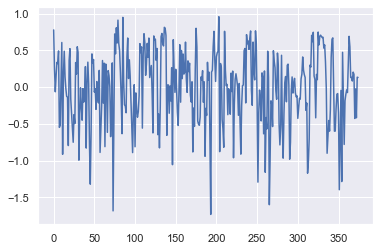

In [84]:
plt.plot(seq)

In [85]:
x_pred = prescaler.inverse_transform(seq)

In [88]:
# plt.plot(x_pred)
# plt.plot(pre_val['daily_counts'])

### HMM Prediction
Fit on standardized data

In [64]:
np.random.seed(0)
K = 6
std_data = np.array(pre_train['daily_counts_std']).reshape(-1,1)
model = GaussianHMM(n_components=K, covariance_type="diag", n_iter=1000).fit(std_data)

seq, state = model.sample(375)

Text(0.5, 1.0, 'Standardized predicted & true values (using HMM) | MSE:3.0576')

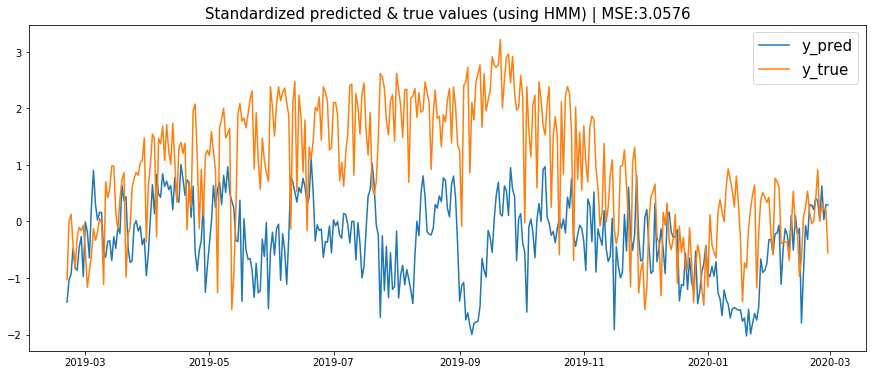

In [78]:
plt.figure(figsize=(15,6))
plt.plot(pre_val['starttime_day'],seq, label = 'y_pred')
plt.plot(pre_val['starttime_day'],pre_val['daily_counts_std'], label = 'y_true')
plt.legend(fontsize=15)
MSE_ = MSE(np.array(seq).flatten())
plt.title('Standardized predicted & true values (using HMM) | MSE:{:.4f}'.format(MSE_), fontsize=15)

Text(0.5, 1.0, 'Scaled predicted & true values (using HMM)')

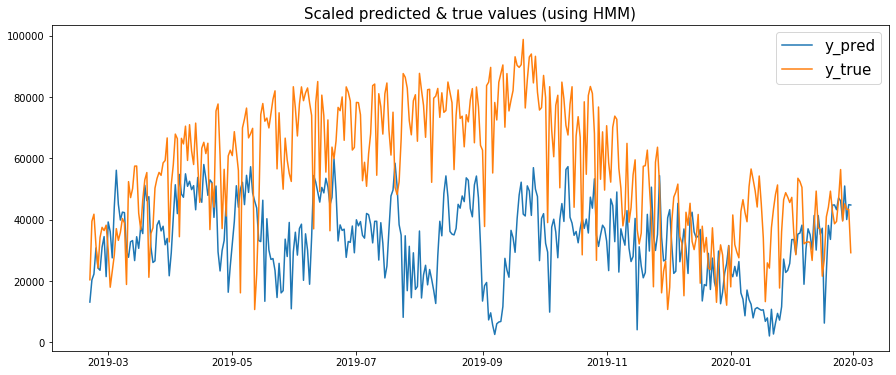

In [80]:
plt.figure(figsize=(15,6))
seq_scale = prescaler.inverse_transform(seq)
plt.plot(pre_val['starttime_day'],seq_scale, label = 'y_pred')
plt.plot(pre_val['starttime_day'],pre_val['daily_counts'], label = 'y_true')
plt.legend(fontsize=15)
#MSE_ = MSE(np.array(seq).flatten())
plt.title('Scaled predicted & true values (using HMM)', fontsize=15)